## Modelling the happiness U-shape (using dynamic programming)

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

---

### Problem Setup and Intuition

The goal of this notebook is to attempt to establish a mathematical foundation for the U-shape in individual wellbeing/happiness over the lifespan.

To do this, I focus on the following general finite-horizon problem of optimal investment into 'capabilities' (health, wisdom, social networks, wealth, etc) to maximise present discounted value of happiness across the lifespan, subject to a law of motion for capabilities:

$$\underset{{K_{t+1}, I_t}}{max} \sum^T_{t=0}\beta^t h(K_t, I_t, t)$$
$$s.t. \: K_{t+1} = f(K_t, I_t, t) \: \forall t$$

where $K_t$ represents the agent's stock of capabilities (with $K_0$ exogenously fixed), $I_t$ represents their period-$t$ investment into building capabilities, and $h(K_t, I_t), t$ represents the agent's happiness in a given period $t$ with capabilities $K_t$ and contemporaneous investment $I_t$. This setup closely resembles a firm's investment problem, hence the similar notation.

This is a problem of reverse engineering (i.e. an inverse problem): the objective is to find functions $h, f$ such that when this problem is solved for optimal $\tilde{K}_t, \tilde{I}_t$, the resulting happiness trajectory $h(\tilde{K}_t, \tilde{I}_t)$ is U-shaped.

I attempt to incorporate the following features of the aging process, which seem useful in this context, into the functional forms of $f$ and $h$:
- investment into capabilities becomes more costly/less effective in old age (due to e.g. declining health, increased difficulty in finding jobs/income, increased difficulty travelling etc which make it harder to engage in the interactions that build up capabilities)
- capabilities depreciate faster in old age (e.g. health declines more quickly, progression of society that you can't keep up with, etc)

My intuition is that these constraining features should lead people to want to avoid going into old age with a low capability stock because this will be very costly in terms of happiness (as it is harder to improve upon capabilities in old age). They therefore need to enter old-age with a good stock of capabilities, and the most efficient way to do that is to invest in midlife, then gradually taper off into old age, due to the depreciation.

This fits with what seems to be the case in reality: people spend a lot of their young to mid adult life finding a partner, raising a family, working hard and climbing the corporate ladder etc, until they eventually retire, the children grow up etc and they are able to reap the rewards for these 'investments'.

---

### Numerical Solution

I solve this problem using dynamic programming: I express it as a Bellman equation and solve it via backward induction. 

The Bellman equation is as follows:
$$V(K_t, t) = \underset{{K_{t+1}, I_t}}{max} \: h(K_t, I_t) + \beta V(K_{t+1}, t+1)$$
$$s.t. \: K_{t+1} = f(K_t, I_t, t)$$

To do this, I define a function that solves the finite-horizon optimisation problem numerically using this backward induction method, and then simulates the solution trajectory from a specified starting point

In [ ]:
def solve_and_simulate(K0, Kmin, Kmax, nK, Imin, Imax, nI, Tsim, beta, h_of_t, K_next):

    # these arguments correspond to:
        # K0: initial capabilities
        # Kmin, Kmax: min and max of K_grid
        # nK: number of grid points for K
        # Imin, Imax: min and max of I_grid
        # nI: number of grid points for I
        # Tsim: number of time periods to simulate
        # gamma_path: array of length Tsim with investment cost parameter for each t
        # delta_path: array of length Tsim with depreciation rate for each t
        # A, alpha, beta: model parameters
        # h_of_t: the function h(K,I,t) that computes period payoff (evaluated on a grid of different values of I)
        # K_next: function to compute next period capabilities

    #### SET UP THE GRID TO DO THE OPTIMISATION OVER

    # set the state and control grids
    K_grid = np.linspace(Kmin, Kmax, nK)
    I_grid = np.linspace(Imin, Imax, nI)

    #### DO BACKWARD INDUCTION TO SOLVE THE TIME-DEPENDENT PROBLEM

    # V[t, iK] will hold value at time t for K_grid[iK]
    # V[Tsim,:] is terminal value = 0 (i.e. no continuation value beyond this point)
    V = np.zeros((Tsim + 1, nK))

    # policy_I_idx[t, iK] will hold index of optimal I in I_grid for each (t, K_grid[iK])
    policy_I_idx = np.zeros((Tsim, nK), dtype=int)

    # now start the backwards loop that calculates V and policy_I_idx for the prior period, given V in the next
    # note that we keep V[Tsim, :] = 0 as the terminal condition: this is the transversality condition (TVC)

    for t in range(Tsim - 1, -1, -1):  # i.e. t = Tsim-1, ..., 0

        # create interpolator for V[t+1, .], taking the values of V for each K in K_grid and linearly interpolating
        Vnext_interp = interp1d(K_grid, V[t + 1], kind='linear', fill_value='extrapolate', assume_sorted=True)

        # loop across K grid to get the V and the policy I for each value of K
        for iK, K in enumerate(K_grid):

            # compute feasible K' for each candidate I (giving a vector) and the given K
            Knext = K_next(K, I_grid, t)

            # clip onto interpolation domain (i.e. if K>Kmax then set to Kmax, and same for Kmin)
            Knext_clipped = np.clip(Knext, Kmin, Kmax)

            # calculate continuation value (i.e. next period V) for each candidate I, given the corresponding K'
            cont_val = Vnext_interp(Knext_clipped)        # V[t+1](K') vector of length nI

            # calculate the immediate payoff vector for all candidate I (again a vector of length nI)
            h_vec = h_of_t(K, I_grid, t)

            # get the total RHS value of the Bellman equation, and then the index of the I that maximises it
            total = h_vec + beta * cont_val               # total value for each I
            jstar = int(np.argmax(total))                 # index of best I

            # store the value and policy function index for the given K
            V[t, iK] = total[jstar]
            policy_I_idx[t, iK] = jstar

        # after looping over all K, we have found the optimal investment function and the value function in time t given K_t
        # the value function is then used in the next loop to get the next period's functions, and so on

    # # some printouts to check things are working
    # print(V[1,])
    # print("now t=2")
    # print(V[2,])
    # print("now the I")
    # print(policy_I_idx[1,])
    # print("now t=2 I")
    # print(policy_I_idx[2,])

    # optional progress printout
    #     # print the progress
    #     if (t % 10) == 0:
    #         print(f'Backward step done: t={t}')
    
    # print('Backward induction finished.')


    # -------------------------
    # Build time-dependent policy function objects for simulation
    # -------------------------
    # get the actual investment values from the optimal indices
    policy_I_vals = I_grid[policy_I_idx]   # shape (Tsim, nK)
    # note this is equivalent to policy_I_vals[t, iK] = I_grid[policy_I_idx[t, iK]]

    # build interpolator for each time period (so we can evaluate I*_t(K) at off-grid K)
    policy_fun = [
        interp1d(K_grid, policy_I_vals[t], kind='linear',
                fill_value=(Imin, Imax), bounds_error=False, assume_sorted=True)
        for t in range(Tsim)
    ]


    #### NOW SIMULATE

    Ks = np.empty(Tsim + 1)
    Is = np.empty(Tsim)
    hs = np.empty(Tsim)
    Ks[0] = K0

    for t in range(Tsim):
        # evaluate policy at current K_t using the t-th policy function
        I_t = float(policy_fun[t](Ks[t]))
        Is[t] = I_t
        # evaluate h at (K_t, I_t)
        hs[t] = h_of_t(Ks[t], I_t, t)
        # update K
        Ks[t + 1] = K_next(Ks[t], I_t, t)


    #### NOW PLOT RESULTS

    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    
    # First plot: K_t (capabilities)
    axs[0, 0].plot(np.arange(Tsim+1), Ks, marker='o', color='blue', markersize=3)
    axs[0, 0].set_title('K_t (capabilities)')
    axs[0, 0].set_xlabel('time t')
    axs[0, 0].grid(True)
    
    # Second plot: I_t (investment policy)
    axs[0, 1].plot(np.arange(Tsim), Is, marker='o', color='red', markersize=3)
    axs[0, 1].set_title('I_t (investment policy)')
    axs[0, 1].set_xlabel('time t')
    axs[0, 1].grid(True)
    
    # Third plot: h_t = h(K_t,I_t) (period payoff) - span both columns in second row
    axs[1, 0].plot(np.arange(Tsim), hs, marker='o', color='green', markersize=3)
    axs[1, 0].set_title('h_t = h(K_t,I_t) (period payoff)')
    axs[1, 0].set_xlabel('time t')
    axs[1, 0].grid(True)
    
    # Hide the unused subplot (bottom right)
    fig.delaxes(axs[1, 1])
    
    plt.tight_layout()
    plt.show()

---

### Baseline Solution

I now use this function to solve the model with some baseline parameter values: first the most basic, with no explicit time-dependence in either $f$ or $h$. In particular, the specific functional forms of $f$ and $h$ that I use are as follows:
$$h(K_t, I_t) = AK_t^\alpha - \gamma_t I_t$$
$$f(K_t, I_t) = (1-\delta_t) K_t + I_t$$
where $A$ gives the 'efficiency' with which an agent uses their capabilities, $\alpha \in (0,1)$ reflects diminishing returns in happiness to the size of the capability stock, $\gamma_t$ reflects the contemporaneous investment cost, and $\delta_t$ represents depreciation of the existing capability stock. In this model, $\gamma_t \equiv \gamma$ and $\delta_t \equiv \delta$.

Note that we start with the capability stock high, at Kmax, to reflect the fact that children have a family around them who provide them with 'everything they need'.

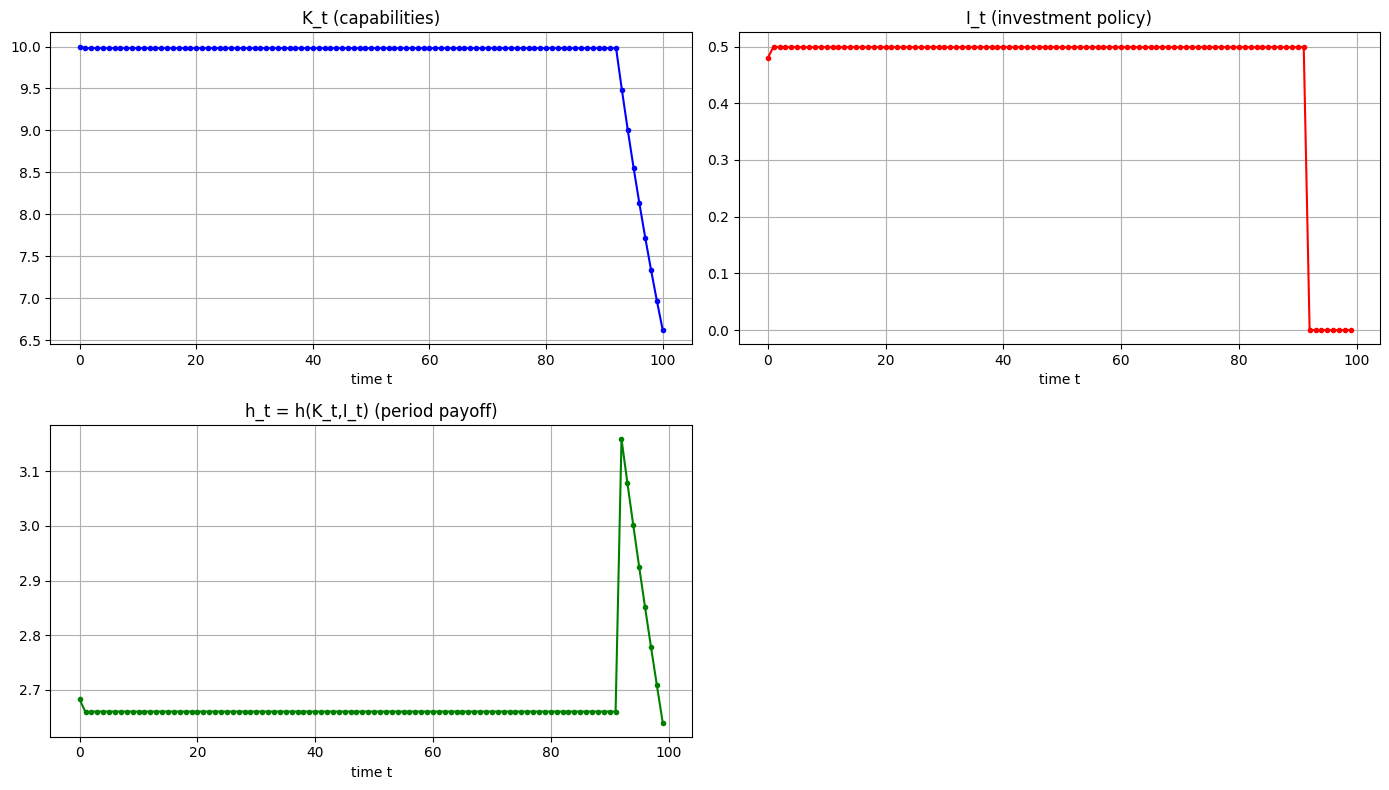

In [3]:
# set parameter values
A = 1.0
alpha = 0.5
beta = 0.98
Tsim = 100  # V[Tsim] is terminal value (set to 0, by the transversality condition under the condition we need capabilities stock positive at final period).
gamma_path = np.linspace(1, 1, Tsim)**2  # constant investment cost over time
delta_path = np.linspace(0.05, 0.05, Tsim)  # constant depreciation over time
K0 = 10  # choose initial capabilities within [Kmin, Kmax] - we want it to start high
Kmin, Kmax, nK = 0.1, 10.0, 100
Imin, Imax, nI = 0.0, 2.5, 100

# define payoff function depending on time t, h(K,I,t), vectorised in I (though we can put a scalar in too)
def h_of_t(K, I_grid, t):
    gamma_t = gamma_path[t]
    return A * (K**alpha) - gamma_t * I_grid

# define the law of motion function, dependent on time t
def K_next(K, I_grid, t):
    delta_t = delta_path[t]
    return (1.0 - delta_t) * K + I_grid

solve_and_simulate(K0, Kmin, Kmax, nK, Imin, Imax, nI, Tsim, beta, h_of_t, K_next)

Interpretation...

---

### Solution with time-dependent depreciation

Now solve the model where now the depreciation rate is an increasing linear function of time: $\delta_t = \delta_0 + \delta_1 t$

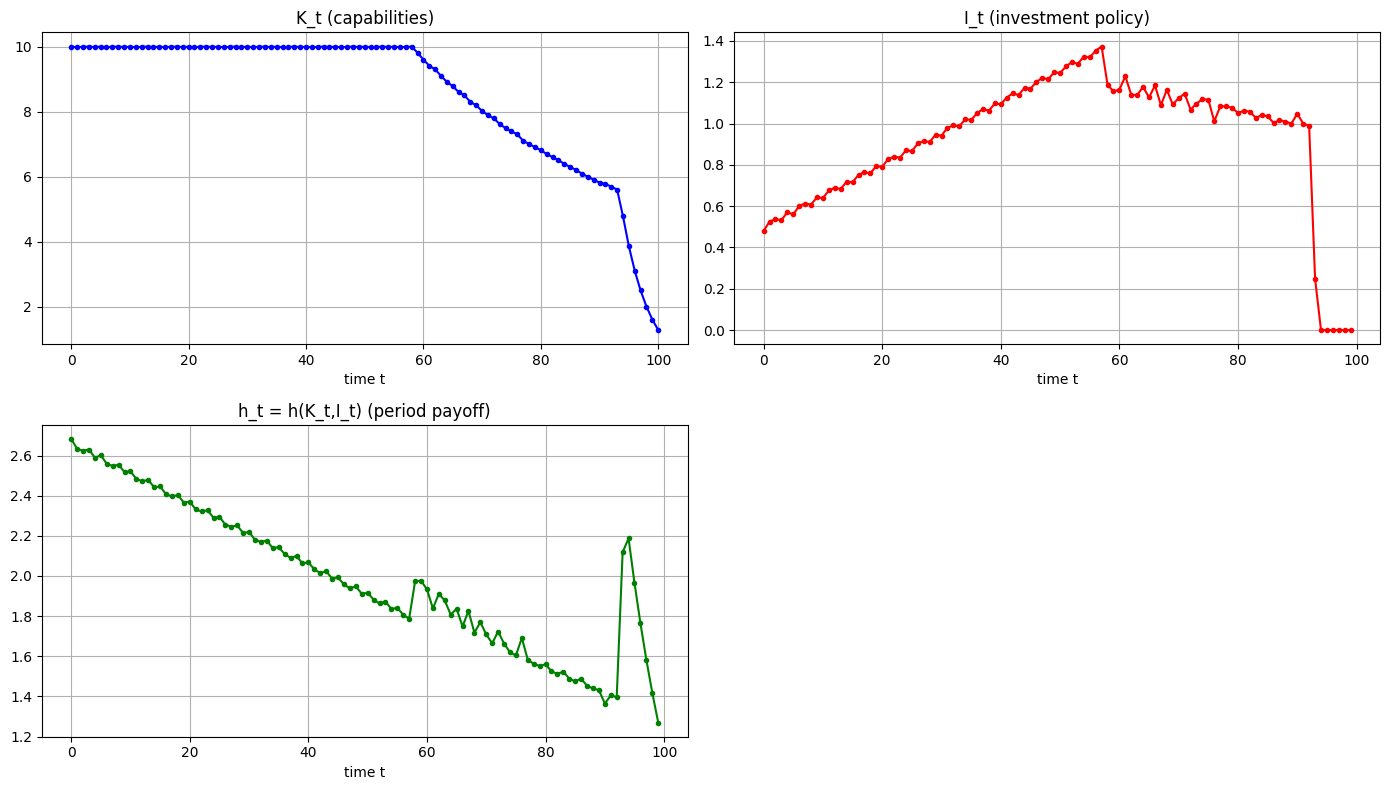

In [4]:
delta_path = np.linspace(0.05, 0.2, Tsim)  # increasing depreciation over time

solve_and_simulate(K0, Kmin, Kmax, nK, Imin, Imax, nI, Tsim, beta, h_of_t, K_next)

Interpret...

---

### Solution with time-dependent investment cost

Now solve the model with an increasing investment cost, but constant depreciation. The investment cost will increase quadratically in $t$: $\gamma_t = (\gamma_0 + \gamma_1 t)^2$

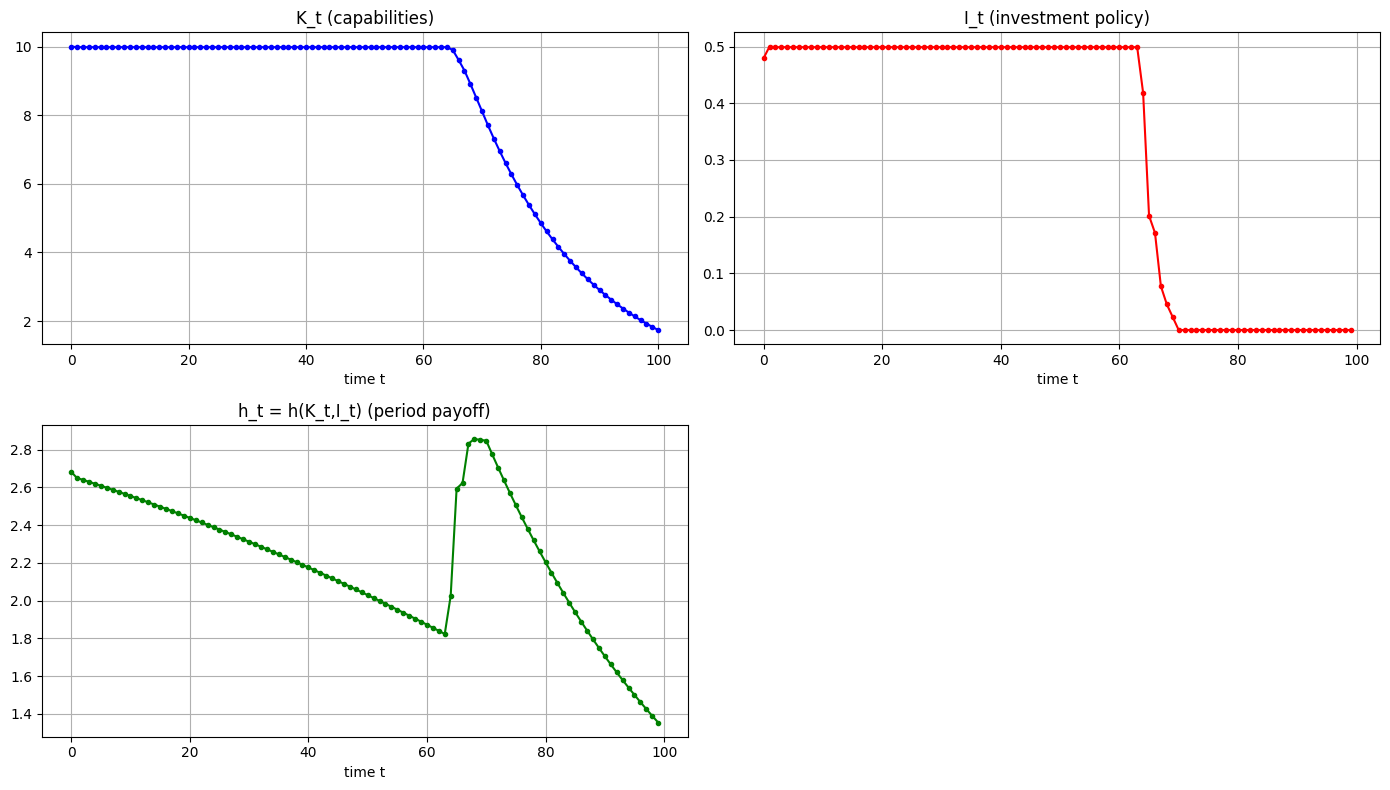

In [5]:
delta_path = np.linspace(0.05, 0.05, Tsim)  # back to constant depreciation
gamma_path = np.linspace(1, 2, Tsim)**2  # increasing polynomial investment cost over time

solve_and_simulate(K0, Kmin, Kmax, nK, Imin, Imax, nI, Tsim, beta, h_of_t, K_next)

Interpret...

---

### Solution with time-dependent depreciation and investment cost 

Now do it in a way that incorporates increasing depreciation and increasing investment cost over time

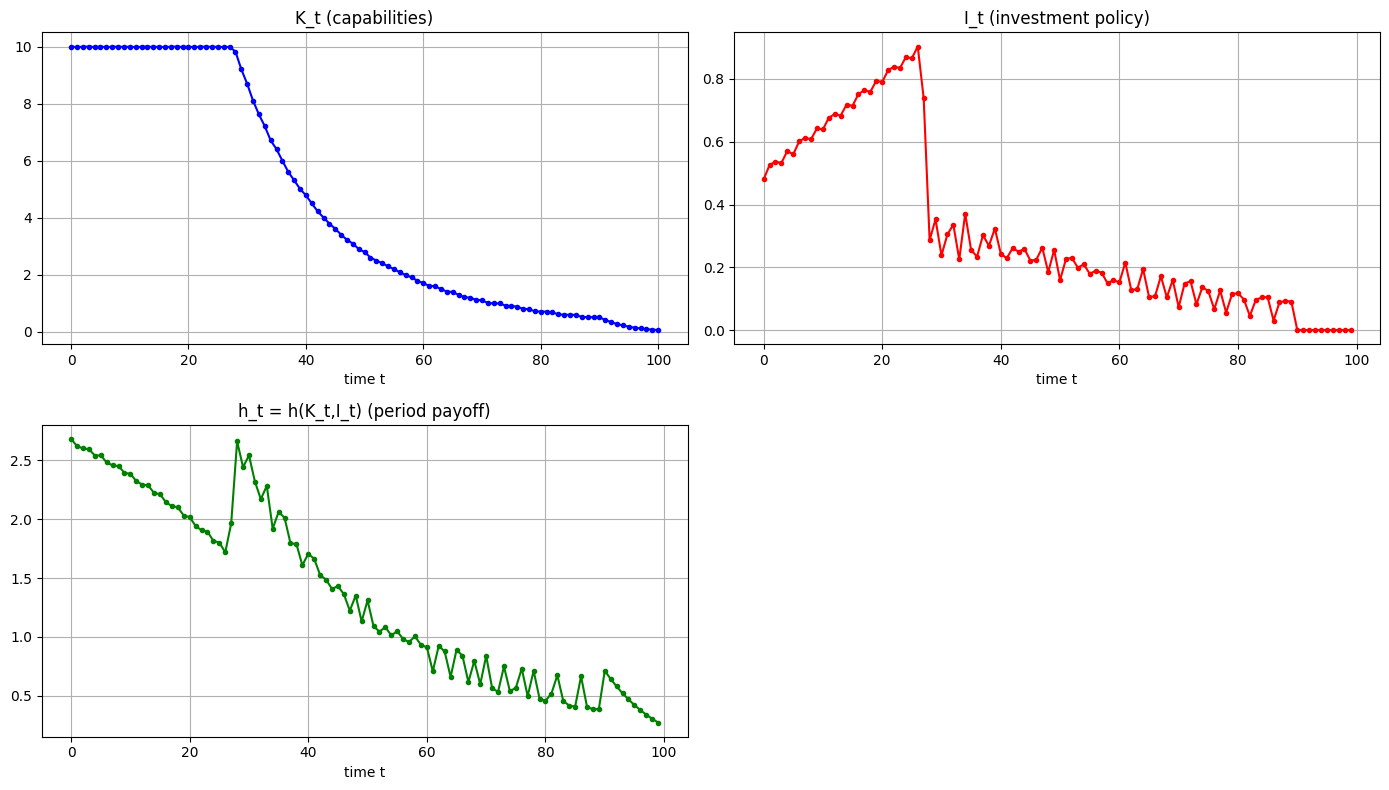

In [6]:
gamma_path = np.linspace(1, 2, Tsim)**2  # increasing polynomial investment cost over time
delta_path = np.linspace(0.05, 0.2, Tsim)  # increasing depreciation over time

solve_and_simulate(K0, Kmin, Kmax, nK, Imin, Imax, nI, Tsim, beta, h_of_t, K_next)

Qualitatively this is better - we have some convex behaviour. However, the happiness trajectory is still decreasing. The natural reason for this is that in the final periods it is clearly optimal to run the capabilities stock down to zero, because agents know when they will die and only internalise their intertemporal payoffs.

As such, it may be necessary to introduce an inter-generational incentive to preserve capabilities into old-age, for example to pass on to children/grandchildren.

This could even be extended to a general equilibrium model of a society collectively aiming to optimally allocate happiness, with intergenerational motives and societal resource constraints and GE conditions

---

### Experimenting

This is a sandbox where I drastically change things to understand the effects the features of the ageing process have

[84.62178839 84.85445771 85.0863522  85.31747388 85.54782686 85.77738664
 86.00612572 86.23407754 86.46132206 86.68803889 86.91407733 87.13941843
 87.36406725 87.58785726 87.81041105 88.03022685 88.24631488 88.45595153
 88.65507838]
now t=2
[83.57111754 83.80155164 84.03127281 84.26039377 84.4887715  84.7164056
 84.94330078 85.16942612 85.39477499 85.6193654  85.84327845 86.0665531
 86.28914042 86.51106397 86.73231108 86.9524948  87.17110553 87.38433293
 87.59056557]
now the I
[22 22 22 22 22 22 22 22 22 21 21 21 21 21 21 20 20 20 18]
now t=2 I
[22 22 22 21 21 21 21 21 21 21 21 21 21 21 21 21 20 20 19]


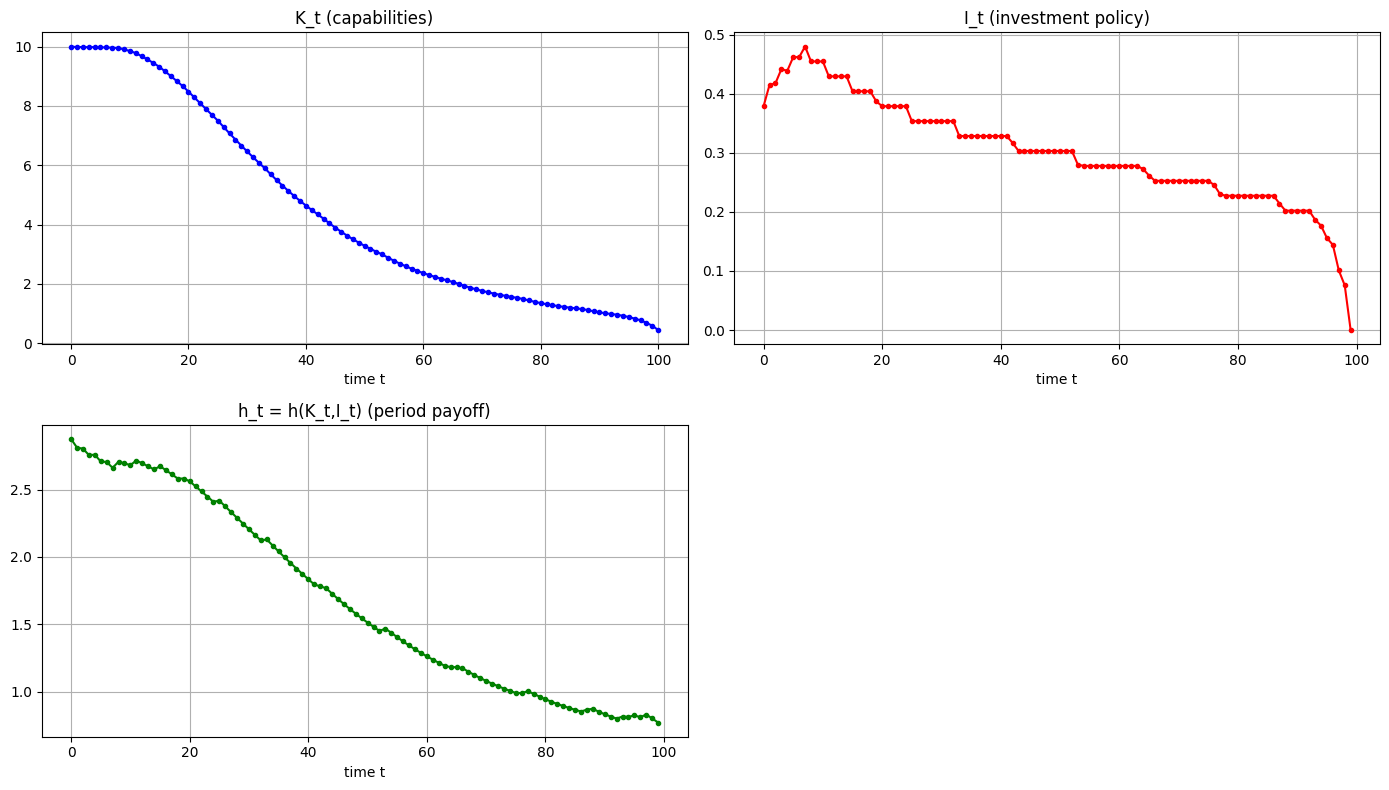

In [77]:
A = 1
alpha = 0.5
beta = 0.98
Tsim = 100  
gamma_path = np.linspace(1, 2, Tsim)**2 + 1
delta_path = np.linspace(0.2, 0.5, Tsim)**2
K0 = 10
Kmin, Kmax, nK = 0.1, 10.0, 100
Imin, Imax, nI = 0.0, 2.5, 100

def h_of_t(K, I_grid, t):
    gamma_t = gamma_path[t]
    return A * (K**alpha) - gamma_t * I_grid**2

def K_next(K, I_grid, t):
    delta_t = delta_path[t]
    return (1.0 - delta_t) * K + I_grid

solve_and_simulate(K0, Kmin, Kmax, nK, Imin, Imax, nI, Tsim, beta, h_of_t, K_next)

We see a very small peak in investment near the start - how to we make this peak bigger and more central?

[73.87525706 74.3150901  74.72146093 75.10915058 75.48395428 75.84915019
 76.20625769 76.5565055  76.90137922 77.24138148 77.57654581 77.90753166
 78.23483707 78.55847837 78.879074   79.19635289 79.51082902 79.8226218
 80.13163695 80.43803278 80.74213785 81.04416801 81.34384666 81.64134219
 81.93664712 82.22981122 82.52124026 82.81098042 83.09895446 83.38520181
 83.6697384  83.95261607 84.23418683 84.51416183 84.79253815 85.0694733
 85.344888   85.61874802 85.89109593 86.16222344 86.43201434 86.70056103
 86.96793626 87.2340704  87.4990418  87.76287908 88.02563103 88.28731705
 88.54781236 88.8071135  89.06522936 89.32214485 89.57795428 89.83285187
 90.08692076 90.34006496 90.59231248 90.84353644 91.09376218 91.34298191
 91.59121304 91.83847253 92.08474012 92.32997308 92.57433453 92.81778666
 93.06011641 93.30117408 93.54078681 93.77888687 94.01546026 94.25093792
 94.48497916 94.7174284  94.94819941 95.17726398 95.40495903 95.63124086
 95.85579143 96.07825267 96.2986598  96.51750859 96.7

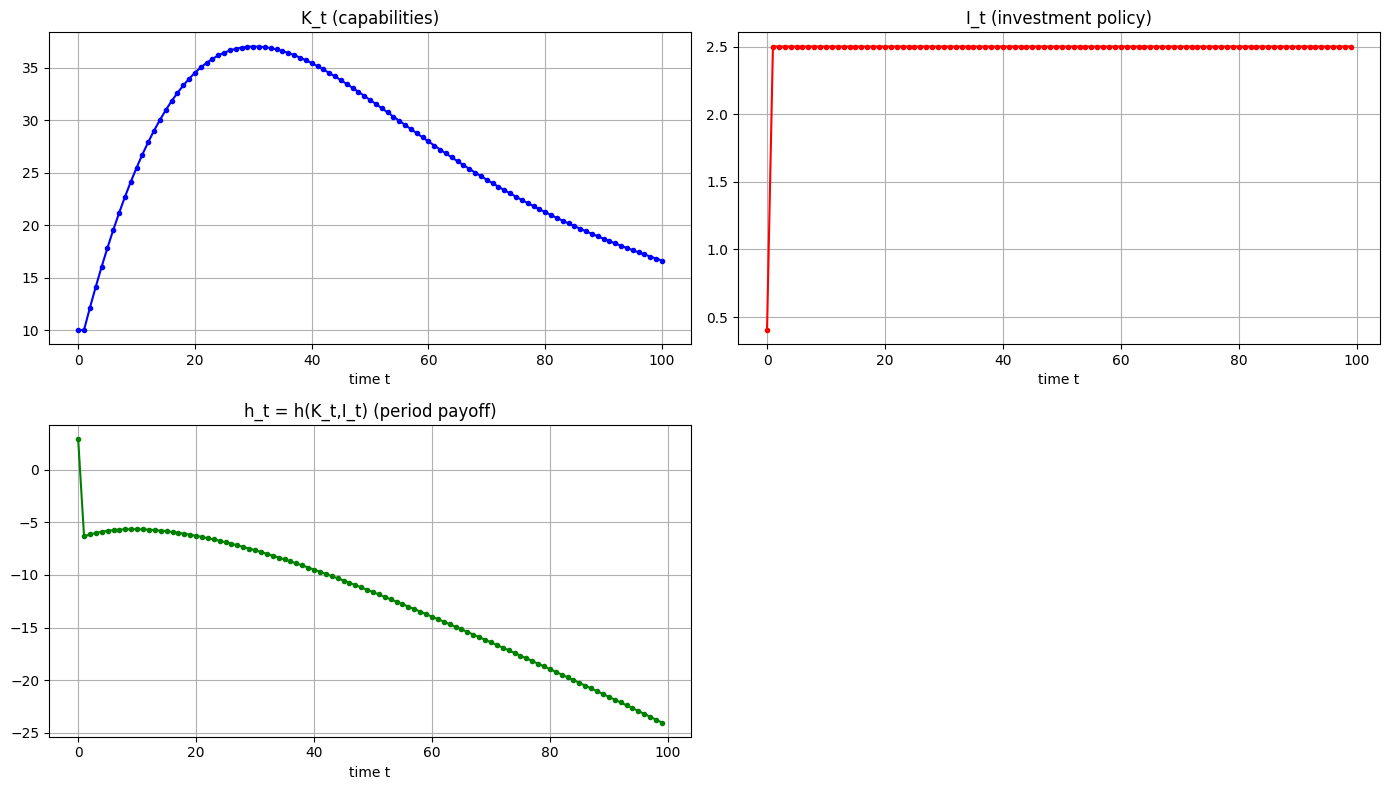

In [79]:
A = 1
alpha = 0.5
beta = 0.98
Tsim = 100
gamma_path = np.linspace(1, 2, Tsim)**2 + 0.5
delta_path = np.linspace(0.2, 0.4, Tsim)**2
K0 = 10
Kmin, Kmax, nK = 0.1, 10.0, 100
Imin, Imax, nI = 0.0, 2.5, 100

def h_of_t(K, I_grid, t):
    gamma_t = gamma_path[t]
    return A * (K**alpha) - gamma_t * I_grid**2

def K_next(K, I_grid, t):
    delta_t = delta_path[t]
    return (1.0 - delta_t) * K + I_grid

solve_and_simulate(K0, Kmin, Kmax, nK, Imin, Imax, nI, Tsim, beta, h_of_t, K_next)

Slowing the rate of depreciation shallows the investment peak and elongates the happiness convexity, but slightly makes it less clear (maybe due to overpowering decline after)

Shifting the gamma down uniformly (close to 1) pushes out the curve, but too much and it goes weird (corner solution issue)

Increasing A pushes out the curve, but again can only do a little bit

Increasing alpha does the same, again with same constraint

Decreasing T too much does the same thing

Pushing beta up to 1 does the same thing

Increasing the amount you can invest (upper I limit) too much does the same thing


I think this convexity comes from the fact you want capital stock at maximum, but you have to progressively invest more each period as depreciation rate rises - this seems like a weak explanation

### Notes from experimenting

- when the depreciation rate is too low, investment quickly hits its max
- when investment cost is too high, we get flat 0 investment and capabilities and happiness decay geometrically towards 0 (with rate dependent on depreciation)
- when initial investment cost is too low we get strange behaviour where capabilities goes above 10 (the max limit) and happiness goes to -lots: issue with the optimisation function?

---

### Notes and questions

It is important to realise the investment schedule we are trying to generate in order to get this happiness U-shape: starts low, then increases, then plateaus/decreases. It is worth thinking about the problem in these terms too.

Question: what is stopping individuals in this model from just accepting that old age will be a period of unhappiness because it is costly to maintain happiness at this stage? This is the key alternative option, which seems to be preferred by most of the model setups